In [46]:
%load_ext autoreload
%autoreload 2
import os
import sys
import logging
import pandas as pd
import numpy as np
import imblearn as imb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from rdkit import Chem
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from atom2024 import utils
logging.basicConfig(level=logging.INFO, stream=sys.stdout)
pd.set_option('display.max_colwidth', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
smile_prop_df = pd.read_csv('data/NEK2/NEK2_1_uM_min_50_pct_binding_5fold_random_imbalanced.csv')

smile_prop_train = smile_prop_df[smile_prop_df['fold'] != 'fold5'].drop(columns=['fold'])
smile_prop_test = smile_prop_df[smile_prop_df['fold'] == 'fold5'].drop(columns=['fold'])

mol_train = []
for i in smile_prop_train.index:
    m = Chem.MolFromSmiles(smile_prop_train.loc[i, 'base_rdkit_smiles'])
    if m:
        m.SetProp("_Name", smile_prop_train.loc[i, 'compound_id'])
        m.SetProp("Active", str(smile_prop_train.loc[i, 'active']))
        mol_train.append(utils.normalize(m))

mol_test = []
for i in smile_prop_test.index:
    m = Chem.MolFromSmiles(smile_prop_test.loc[i, 'base_rdkit_smiles'])
    if m:
        m.SetProp("_Name", smile_prop_test.loc[i, 'compound_id'])
        m.SetProp("Active", str(smile_prop_test.loc[i, 'active']))
        mol_test.append(utils.normalize(m))


In [36]:
with Chem.SDWriter('data/NEK2/NEK2_1_uM_min_50_pct_binding_5fold_random_imbalanced_train.sdf') as writer:
    for m in mol_train:
        writer.write(m)

with Chem.SDWriter('data/NEK2/NEK2_1_uM_min_50_pct_binding_5fold_random_imbalanced_test.sdf') as writer:
    for m in mol_test:
        writer.write(m)

In [39]:
X_existing_train = smile_prop_train.drop(columns=['compound_id', 'base_rdkit_smiles', 'active'])
X_existing_test = smile_prop_test.drop(columns=['compound_id', 'base_rdkit_smiles', 'active'])
y_train = smile_prop_train['active']
y_test = smile_prop_test['active']

# generate fingeprints: Morgan fingerprint with radius 2
fps = [Chem.AllChem.GetMorganFingerprintAsBitVect(m, 2) for m in mol_train]
# convert the RDKit explicit vectors into numpy arrays
X_morgan_train = []
for fp in fps:
  arr = np.zeros((1,))
  Chem.DataStructs.ConvertToNumpyArray(fp, arr)
  X_morgan_train.append(arr)

# generate fingeprints: Morgan fingerprint with radius 2
fps = [Chem.AllChem.GetMorganFingerprintAsBitVect(m, 2) for m in mol_test]
# convert the RDKit explicit vectors into numpy arrays
X_morgan_test = []
for fp in fps:
  arr = np.zeros((1,))
  Chem.DataStructs.ConvertToNumpyArray(fp, arr)
  X_morgan_test.append(arr)


Accuracy: 0.9572953736654805


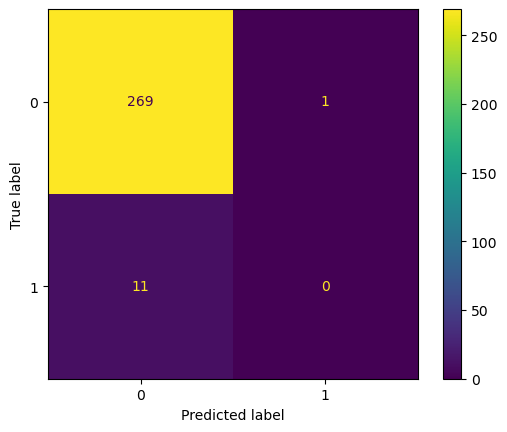

In [42]:
rf = RandomForestClassifier()

rf.fit(X_existing_train, y_train)

y_pred = rf.predict(X_existing_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

Accuracy: 0.9679715302491103


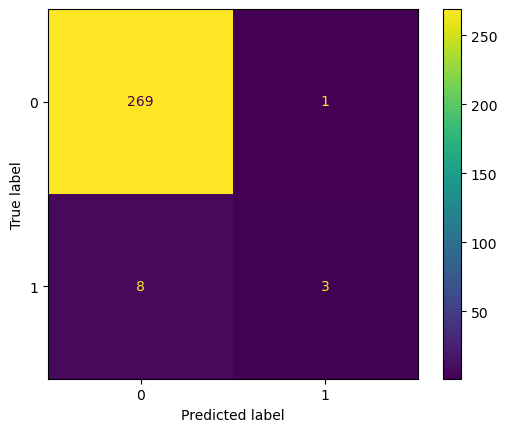

In [43]:
rf = RandomForestClassifier()

rf.fit(X_morgan_train, y_train)

y_pred = rf.predict(X_morgan_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

Accuracy: 0.9572953736654805


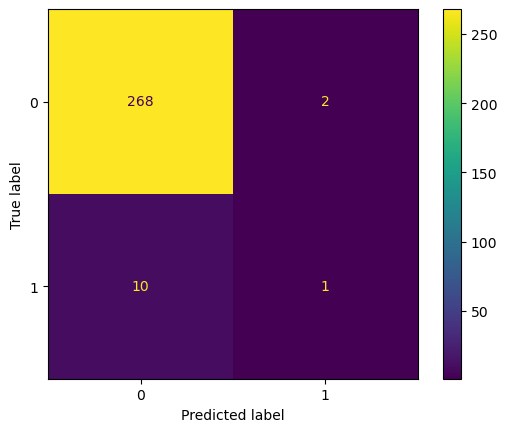

In [49]:
oversample = imb.over_sampling.RandomOverSampler()
X_os_train, y_os_train = oversample.fit_resample(X_existing_train, y_train)

rf = RandomForestClassifier()

rf.fit(X_os_train, y_os_train)

y_pred = rf.predict(X_existing_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

Accuracy: 0.9572953736654805


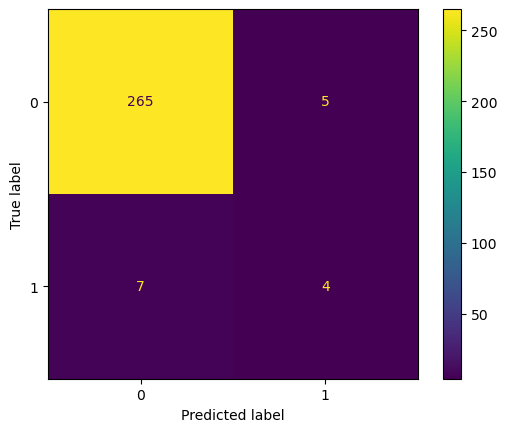

In [50]:
oversample = imb.over_sampling.RandomOverSampler()
X_os_train, y_os_train = oversample.fit_resample(X_morgan_train, y_train)

rf = RandomForestClassifier()

rf.fit(X_os_train, y_os_train)

y_pred = rf.predict(X_morgan_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();